## General Information

Team Compositions in Dota2 explored the idea that hero selection affected the win rate primarily using Logistic Regression Models as our base line

#### To simplify you navigation through this kernel:

    *Change to your own path in order to read the csv file*
    
    Main data exploration:
        1: Feacture Engineering
        2: Predictive Modelling
        3: Model Evaluation Metrics
            -Classification Accuracy
            -F-Measure
            -Logarithmic Loss
            -Area under curve (AUC)

## Change to your path

In [1]:
import os
import pandas as pd
os.chdir(r"C:\Users\chena\Desktop\dota-2-matches\code\all_csv_files")

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
players = pd.read_csv('players.csv')
matches = pd.read_csv('match.csv')
heroes = pd.read_csv('hero_names.csv')

Let us map the hero_id field to its name.

## 1: Feacture Engineering

In [4]:
hero_lookup = dict(zip(heroes['hero_id'], heroes['localized_name']))
hero_lookup[0] = 'Unknown'
players['hero'] = players['hero_id'].apply(lambda _id: hero_lookup[_id])

In [5]:
# lineup={}
# for j in range(50000):
#     z=j*10
#     radiant=[]
#     dire=[]
#     matches_hero={}
#     for i in range(5):
#         print((i+z))
#         print(players.iloc[i+z]['hero'])
#         radiant.append(players.iloc[i+z]['hero'])
#         dire.append(players.iloc[i+z+5]['hero'])
#     matches_hero['radiant']=radiant
#     matches_hero['dire']=dire
#     lineup[j]=matches_hero

In [6]:
# import json
# with open('match_lineup.json', 'w') as fp:
#     json.dump(lineup, fp)

Convert categorical variable into dummy/indicator variables.

In [7]:
player_heroes = pd.get_dummies(players['hero'])

In [8]:
player_heroes.head()

,Abaddon,Alchemist,Ancient Apparition,Anti-Mage,Axe,Bane,Batrider,Beastmaster,Bloodseeker,Bounty Hunter,...,Venomancer,Viper,Visage,Warlock,Weaver,Windranger,Winter Wyvern,Witch Doctor,Wraith King,Zeus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let us prepare the column names for every hero name for every team:

In [9]:
radiant_cols = list(map(lambda s: 'radiant_' + s, player_heroes.columns.values))
dire_cols = list(map(lambda s: 'dire_' + s, player_heroes.columns.values))

The result is a row that encodes whether or not (1 or 0) a type of hero is present for that team and also the sum of the combined item counts for every team - (getting the item per player will be more memory intensive that is why we are combining per team).

In [10]:
from os.path import isfile

X = None


radiant_heroes = []
dire_heroes = []

for _id, _index in players.groupby('match_id').groups.items():
    radiant_heroes.append(player_heroes.iloc[_index][:5].sum().values)
    dire_heroes.append(player_heroes.iloc[_index][5:].sum().values)

In [11]:
radiant_heroes = pd.DataFrame(radiant_heroes, columns=radiant_cols)
dire_heroes = pd.DataFrame(dire_heroes, columns=dire_cols)

Concatenate pandas objects along a particular axis with optional set logic along the other axes.

In [12]:
X = pd.concat([radiant_heroes, dire_heroes], axis=1)
X.head()

,radiant_Abaddon,radiant_Alchemist,radiant_Ancient Apparition,radiant_Anti-Mage,radiant_Axe,radiant_Bane,radiant_Batrider,radiant_Beastmaster,radiant_Bloodseeker,radiant_Bounty Hunter,...,dire_Venomancer,dire_Viper,dire_Visage,dire_Warlock,dire_Weaver,dire_Windranger,dire_Winter Wyvern,dire_Witch Doctor,dire_Wraith King,dire_Zeus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [13]:
# exposrt to csv
# X.to_csv('mapped_match_hero.csv', index=False)

Now, let us properly encode the target column:

In [14]:
y = matches['radiant_win'].apply(lambda win: 1 if win else 0)
classes = ['Dire Win', 'Radiant Win']

## 2. Predictive Modelling (Logistic Regression)

In [15]:
# First, we import python libraries which we will use for modelling and visualing the final model:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import accuracy_score

In [16]:
#generate the same set of random numbers
seed = 7
#cross-validation settings
kfold = model_selection.KFold(n_splits=10, random_state=seed)

C:\Users\chena\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


### 3. Evaluate model performance

In [17]:
#Model instance
model = LogisticRegression()
#Evaluate model performance
scoring = 'accuracy'
results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
print('Accuracy -val set: %.2f%% (%.2f)' % (results.mean()*100, results.std()))

Accuracy -val set: 60.02% (0.01)


#### The classification accuracy is 60.02% on the validation set.
By using cross-validation, we’d be “testing” our machine learning model in the “training” phase to check for overfitting and to get an idea about how our machine learning model will generalize to independent data (test data set).

In [18]:
#split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=seed)
#fit model
model.fit(X_train, y_train)
#accuracy on test set
result = model.score(X_test, y_test)
print("Accuracy - test set: %.2f%%" % (result*100.0))

Accuracy - test set: 60.43%


### The classification accuracy is 60.43% on the test set. However, Our team feel that this model could be improved by adding features such as Hero_counter and synergy.  

### F1-Measure

F-measure (also F-score) is a measure of a test’s accuracy that considers both the precision and the recall of the test to compute the score. Precision is the number of correct positive results divided by the total predicted positive observations. Recall, on the other hand, is the number of correct positive results divided by the number of all relevant samples (total actual positives).

In [19]:
predictions = model.predict(X_test)
predictions

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [20]:
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

Precision: 0.610945
Recall: 0.660519
F1 score: 0.634766


### Logarithmic Loss
Logarithmic loss (logloss) measures the performance of a classification model where the prediction input is a probability value between 0 and 1. Log loss increases as the predicted probability diverges from the actual label. The goal of machine learning models is to minimize this value. As such, smaller logloss is better, with a perfect model having a log loss of 0.

In [21]:
from sklearn.metrics import log_loss
accuracy = log_loss(y_test, predictions)
print("Logloss: %.2f" % (accuracy))

Logloss: 13.67


### Area under Curve (AUC)
Area under ROC Curve is a performance metric for measuring the ability of a binary classifier to discriminate between positive and negative classes.

AUC - Test Set: 64.10%


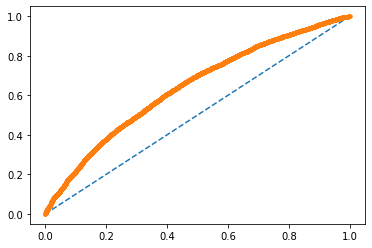

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve

# predict probabilities
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

In the example above, the AUC is relatively close to 1 and greater than 0.5. A perfect classifier will have the ROC curve go along the Y axis and then along the X axis.